In [36]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')

In [38]:
# Find the url for 10 pages
base_url="https://www.imdb.com/search/title/?title_type=feature\
&release_date=1930-01-01,2020-12-31\
&countries=us&keywords=based+on+novel\
&languages=en&count=100"

url_list=[base_url]
for i in range(101,2001,100):
    url = base_url+ "&start=" + str(i) + "&ref_=adv_nxt"
    url_list.append(url)

In [39]:
len(url_list)

20

In [40]:
# Create soup_list (13 soup for 13 pages)
def get_soup(url):
    response = requests.get(url)
    page = response.text
    soup = BeautifulSoup(page, "lxml")
    return soup

In [41]:
soup_list=[]
for url in url_list:
    soup_list.append(get_soup(url))

In [42]:
len(soup_list)

20

In [43]:
# Create movie_div_list (2000 movies, 100 movies a page)
# sort by popularity
movie_div_list=[]
for soup in soup_list:
    for movie in soup.find_all('div',class_="lister-item-content"):
        movie_div_list.append(movie)

In [44]:
len(movie_div_list)

2000

In [45]:
# Create movie_url_list (individual webpage for each movie)

movie_url_list=[]
movie_base_url = "https://www.imdb.com/"

for soup in soup_list:
    divs= [div for div in soup.find_all('div', class_="lister-item-content")]

    for i in range(100):
        movie_url = divs[i].find('a').get('href')
        movie_url_list.append(movie_base_url + movie_url)

In [46]:
len(movie_url_list)

2000

In [47]:
# Create soup_list for the movies

movie_soup_list=[]
for movie_url in movie_url_list[:100]:
    movie_soup = get_soup(movie_url)
    movie_soup_list.append(movie_soup)

In [48]:
len(movie_soup_list)

100

In [49]:

for movie_url in movie_url_list[100:200]:
    movie_soup = get_soup(movie_url)
    movie_soup_list.append(movie_soup)

In [50]:
len(movie_soup_list)

200

In [51]:
for movie_url in movie_url_list[200:500]:
    movie_soup = get_soup(movie_url)
    movie_soup_list.append(movie_soup)

In [52]:
len(movie_soup_list)

500

In [53]:
for movie_url in movie_url_list[500:800]:
    movie_soup = get_soup(movie_url)
    movie_soup_list.append(movie_soup)

In [54]:
len(movie_soup_list)

800

In [55]:
for movie_url in movie_url_list[800:]:
    movie_soup = get_soup(movie_url)
    movie_soup_list.append(movie_soup)

In [56]:
len(movie_soup_list)

2000

In [85]:
# get detailed data from individual movie webpage

def get_movie_detail(soup):
    """
    Getting detailed data from individual movie webpage
    """
    
    headers=['movie_title', 'rating', 'vote', 'certificate', 'genre', 'release_date', 'metascore', 'keywords','budget',\
            'opening_weekend_usa','gross_usa','gross_world','runtime','director','link_d','writer','link_w',\
             'star','link_s','distributor','language','country']
    
    # find movie title
    title = " ".join(soup.find('h1').text.split()[:-1]) ## problem?
    
    # find rating
    rating = float(soup.find('span',attrs={'itemprop':'ratingValue'}).text)
    
    # find vote (rating count)
    vote = int(soup.find('span',attrs={'itemprop':'ratingCount'}).text.replace(',',''))
    
    # find content rating
    certificate = soup.find('div', class_="subtext").text.split()[0]
    
    # find list of genre
    genre_list=[]
    for genres in soup.find('div', class_="subtext").find_all('a')[:-1]:
        genre_list.append(genres.text)
        
    # find release date
    date_pre = soup.find('div', class_="subtext").find_all('a')[-1].text.split('(')[0]
    date = pd.to_datetime(date_pre) ## why is it Timestamp? format ='%d-%B-%Y'
    
    # find metascorre
    if soup.find('div',class_="metacriticScore score_favorable titleReviewBarSubItem") is not None:
        meta = int(soup.find('div',class_="metacriticScore score_favorable titleReviewBarSubItem").text.strip('\n'))
    else:
        meta = np.nan
        
        
    # find plot keywords
    keyword_list=[]
    for keywords in soup.find('div', class_="article", id="titleStoryLine").\
    find('div', class_="see-more inline canwrap").find_all('a')[:-1]:
        keyword_list.append(keywords.text.strip(' '))
        
    
    
    # find budget, opening weekend USA, gross USA, cumulative worldwide gross
    # assign default value:
    budget, opening, gross_usa, gross_cw, distributor = np.nan, np.nan, np.nan, np.nan, np.nan
    for line in soup.find('div', class_="article", id="titleDetails").find_all('h4'):        
        if "Budget:" in line:
            budget = int(''.join(s for s in line.next_sibling if s.isdigit()))
        if "Opening Weekend USA:" in line:
            opening = int(''.join(s for s in line.next_sibling if s.isdigit()))
        if "Gross USA:" in line:
            gross_usa = int(''.join(s for s in line.next_sibling if s.isdigit()))
        if "Cumulative Worldwide Gross:" in line:
            gross_cw = int(''.join(s for s in line.next_sibling if s.isdigit()))
        if "Production Co:" in line:
            distributor = line.findNext().text.replace(' ','')

#     # find runtime
#     if soup.find('div', class_="title_wrapper").find('time') is not None:
#         rt = soup.find('div', class_="title_wrapper").find('time').text.replace('\n','').split()
#         hr = "".join(filter(str.isdigit, rt[0]))
#         if len(rt) > 2:
#             min = "".join(filter(str.isdigit, rt[1]))
#         else:
#             min = "0"
#         runtime = int(hr)*60 + int(min)
#     else:
#         runtime = np.nan
        
    # find runtime
    runtime = np.nan
    try:
        runtime = int(soup.find_all('time')[-1].text.strip(' min'))
    except:
        pass
        
        
        
        
    # find director
    director= np.nan
    director = soup.find('div',class_="credit_summary_item").find('a').text
    link_d = soup.find('div',class_="credit_summary_item").find('a').get('href')
    
    # find writer
    writer = np.nan
    writer_line = soup.find_all('div',class_="credit_summary_item")[1].find_all('a')
    link_w = [w.get('href') for w in writer_line]
    writer = [w.text for w in writer_line]
    if '1 more credit' in writer:
        writer.remove('1 more credit')
        link_w.pop()
        
    # find star
    star = np.nan
    star_line = soup.find_all('div',class_="credit_summary_item")[2].find_all('a')
    link_s = [s.get('href') for s in star_line]
    star = [s.text for s in star_line]
    if 'See full cast & crew' in star:
        star.remove('See full cast & crew')
        link_s.pop()
    
    
    
    # find language
    language= np.nan
    t= []
    matching = []
    for div in soup.find('div', class_="article", id="titleDetails").find_all('div'):
        t.append(div.text.replace('\n','').replace(' ',''))
    
    matching = [s for s in t if 'Language:' in s]
    language = matching[0].replace(':',' ').replace('|',' ').split(' ')[1:]
    
    
    # find country
    country= np.nan
    t= []
    matching = []
    for div in soup.find('div', class_="article", id="titleDetails").find_all('div'):
        t.append(div.text.replace('\n','').replace(' ',''))
    
    matching = [s for s in t if 'Country:' in s]
    country = matching[0].replace(':',' ').replace('|',' ').split(' ')[1:]
    
        
    movie_dict = dict(zip(headers, [title,
                                    rating,
                                    vote,
                                   certificate,
                                   genre_list,
                                   date,
                                   meta,
                                   keyword_list,
                                   budget,
                                   opening,
                                   gross_usa,
                                   gross_cw,
                                   runtime,
                                   director,
                                    link_d,
                                    writer,
                                    link_w,
                                    star,
                                    link_s,
                                   distributor,
                                   language,
                                   country]))
    
    return movie_dict

In [62]:
# Create list of movie_dict
movie_detail_data=[]
for movie_soup in movie_soup_list:
    movie = get_movie_detail(movie_soup)
    movie_detail_data.append(movie)

In [63]:
len(movie_detail_data)

2000

In [74]:
# Create pd DataFrame of 2000 movies!
movie_df = pd.DataFrame(movie_detail_data)
movie_df.sort_values('gross_world',ascending=False).head(10)

,movie_title,rating,vote,certificate,genre,release_date,metascore,keywords,budget,opening_weekend_usa,...,runtime,director,link_d,writer,link_w,star,link_s,distributor,language,country
19,Harry Potter and the Deathly Hallows: Part 2,8.1,761802,PG-13,"[Adventure, Drama, Fantasy]",2011-07-15,85.0,"[ginny weasley character, lucius malfoy charac...",125000000.0,169189427.0,...,130.0,David Yates,/name/nm0946734/,"[Steve Kloves, J.K. Rowling]","[/name/nm0460141/, /name/nm0746830/]","[Daniel Radcliffe, Emma Watson, Rupert Grint]","[/name/nm0705356/, /name/nm0914612/, /name/nm0...",WarnerBros.,[English],"[UK, USA]"
18,The Lord of the Rings: The Return of the King,8.9,1638112,PG-13,"[Action, Adventure, Drama]",2003-12-17,94.0,"[epic, orc, hobbit, ring, battle]",94000000.0,72629713.0,...,192.0,Peter Jackson,/name/nm0001392/,"[J.R.R. Tolkien, Fran Walsh, 2 more credits]","[/name/nm0866058/, /name/nm0909638/, fullcredi...","[Elijah Wood, Viggo Mortensen, Ian McKellen]","[/name/nm0000704/, /name/nm0001557/, /name/nm0...",NewLineCinema,"[English, Quenya, OldEnglish, Sindarin]","[NewZealand, USA]"
184,Pirates of the Caribbean: On Stranger Tides,6.6,480218,PG-13,"[Action, Adventure, Fantasy]",2011-05-20,NaN,"[pirate, captain, blackbeard, soldier, revenge]",250000000.0,90151958.0,...,137.0,Rob Marshall,/name/nm0551128/,"[Ted Elliott, Terry Rossio, 7 more credits]","[/name/nm0254645/, /name/nm0744429/, fullcredi...","[Johnny Depp, Penélope Cruz, Ian McShane]","[/name/nm0000136/, /name/nm0004851/, /name/nm0...",WaltDisneyPictures,"[English, Spanish]","[USA, UK]"
53,Jurassic Park,8.1,865330,PG-13,"[Action, Adventure, Sci-Fi]",1993-06-11,68.0,"[dinosaur, tyrannosaurus rex, sneeze, severed ...",63000000.0,47026828.0,...,127.0,Steven Spielberg,/name/nm0000229/,"[Michael Crichton, Michael Crichton]","[/name/nm0000341/, /name/nm0000341/]","[Sam Neill, Laura Dern, Jeff Goldblum]","[/name/nm0000554/, /name/nm0000368/, /name/nm0...",UniversalPictures,"[English, Spanish]",[USA]
202,Alice in Wonderland,6.4,383347,PG,"[Adventure, Family, Fantasy]",2010-03-05,NaN,"[alice in wonderland, alice character, shrinki...",200000000.0,116101023.0,...,108.0,Tim Burton,/name/nm0000318/,"[Linda Woolverton, Lewis Carroll]","[/name/nm0941314/, /name/nm0140902/]","[Mia Wasikowska, Johnny Depp, Helena Bonham Ca...","[/name/nm1985859/, /name/nm0000136/, /name/nm0...",WaltDisneyPictures,[English],"[USA, UK]"
28,The Hobbit: An Unexpected Journey,7.8,755808,PG-13,"[Adventure, Fantasy]",2012-12-14,NaN,"[wizard, hobbit, dragon, dwarf, orc]",180000000.0,84617303.0,...,182.0,Peter Jackson,/name/nm0001392/,"[Fran Walsh, Philippa Boyens, 3 more credits]","[/name/nm0909638/, /name/nm0101991/, fullcredi...","[Martin Freeman, Ian McKellen, Richard Armitage]","[/name/nm0293509/, /name/nm0005212/, /name/nm0...",Metro-Goldwyn-Mayer(MGM),[English],"[NewZealand, USA]"
2,Harry Potter and the Sorcerer's Stone,7.6,654936,PG,"[Adventure, Family, Fantasy]",2001-11-16,64.0,"[magic, wizard, school of magic, based on nove...",125000000.0,90294621.0,...,159.0,Chris Columbus,/name/nm0001060/,"[J.K. Rowling, Steve Kloves]","[/name/nm0746830/, /name/nm0460141/]","[Daniel Radcliffe, Rupert Grint, Richard Harris]","[/name/nm0705356/, /name/nm0342488/, /name/nm0...",WarnerBros.,[English],"[UK, USA]"
41,Harry Potter and the Deathly Hallows: Part 1,7.7,477337,PG-13,"[Adventure, Family, Fantasy]",2010-11-19,65.0,"[based on young adult novel, harry potter movi...",150000000.0,125017372.0,...,146.0,David Yates,/name/nm0946734/,"[Steve Kloves, J.K. Rowling]","[/name/nm0460141/, /name/nm0746830/]","[Daniel Radcliffe, Emma Watson, Rupert Grint]","[/name/nm0705356/, /name/nm0914612/, /name/nm0...",WarnerBros.,[English],"[UK, USA]"
176,The Jungle Book,7.4,258648,PG,"[Adventure, Drama, Family]",2016-04-15,77.0,"[jungle, wolf, fire, tiger, black panther]",175000000.0,103261464.0,...,106.0,Jon Favreau,/name/nm0269463/,"[Justin Marks, Rudyard Kipling]","[/name/nm1098479/, /name/nm0456017/]","[Neel Sethi, Bill Murray, Be

In [75]:
# Save the data to pickle file
movie_df.to_pickle('../dump/movie_data')

### Simple data visualization

In [76]:
# Test loading data from dump
movie_df = pd.read_pickle('../dump/movie_data')

In [77]:
movie_df

,movie_title,rating,vote,certificate,genre,release_date,metascore,keywords,budget,opening_weekend_usa,...,runtime,director,link_d,writer,link_w,star,link_s,distributor,language,country
0,After We Collided,5.0,16457,R,"[Drama, Romance]",2020-10-23,NaN,"[sequel, birthday, boyfriend girlfriend sex, b...",NaN,422899.0,...,105.0,Roger Kumble,/name/nm0474955/,"[Anna Todd, Mario Celaya]","[/name/nm6849771/, /name/nm8800659/]","[Josephine Langford, Hero Fiennes Tiffin, Dyla...","[/name/nm6466214/, /name/nm2842005/, /name/nm0...",CalMaple,"[English, Chinese]",[USA]
1,The Godfather,9.2,1614204,R,"[Crime, Drama]",1972-03-24,100.0,"[crime family, mafia, patriarch, organized cri...",6000000.0,302393.0,...,175.0,Francis Ford Coppola,/name/nm0000338/,"[Mario Puzo, Francis Ford Coppola]","[/name/nm0701374/, /name/nm0000338/]","[Marlon Brando, Al Pacino, James Caan]","[/name/nm0000008/, /name/nm0000199/, /name/nm0...",ParamountPictures,"[English, Italian, Latin]",[USA]
2,Harry Potter and the Sorcerer's Stone,7.6,654936,PG,"[Adventure, Family, Fantasy]",2001-11-16,64.0,"[magic, wizard, school of magic, based on nove...",125000000.0,90294621.0,...,159.0,Chris Columbus,/name/nm0001060/,"[J.K. Rowling, Steve Kloves]","[/name/nm0746830/, /name/nm0460141/]","[Daniel Radcliffe, Rupert Grint, Richard Harris]","[/name/nm0705356/, /name/nm0342488/, /name/nm0...",WarnerBros.,[English],"[UK, USA]"
3,Unknown,6.8,248673,PG-13,"[Action, Thriller]",2011-02-18,NaN,"[amnesia, coma, airport, scientist, nurse]",30000000.0,21856389.0,...,113.0,Jaume Collet-Serra,/name/nm1429471/,"[Oliver Butcher, Stephen Cornwell]","[/name/nm0124700/, /name/nm0180508/]","[Liam Neeson, Diane Kruger, January Jones]","[/name/nm0000553/, /name/nm1208167/, /name/nm0...",DarkCastleEntertainment,"[English, German, Turkish, Arabic]","[UK, Germany, France, USA]"
4,The Lord of the Rings: The Fellowship of the Ring,8.8,1656253,PG-13,"[Action, Adventure, Drama]",2001-12-19,92.0,"[ring, quest, hobbit, epic, elf]",93000000.0,47211490.0,...,171.0,Peter Jackson,/name/nm0001392/,"[J.R.R. Tolkien, Fran Walsh, 2 more credits]","[/name/nm0866058/, /name/nm0909638/, fullcredi...","[Elijah Wood, Ian McKellen, Orlando Bloom]","[/name/nm0000704/, /name/nm0005212/, /name/nm0...",NewLineCinema,"[English, Sindarin]","[NewZealand, USA]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,From the Terrace,6.7,2437,Passed,"[Drama, Romance]",1960-09-09,NaN,"[mother son relationship, wilmington delaware,...",NaN,NaN,...,149.0,Mark Robson,/name/nm0733476/,"[John O'Hara, Ernest Lehman]","[/name/nm0641274/, /name/nm0499626/]","[Paul Newman, Joanne Woodward, Myrna Loy]","[/name/nm0000056/, /name/nm0940946/, /name/nm0...",Linebrook,[English],[USA]
1996,V.I. Warshawski,5.0,4713,R,"[Action, Comedy, Crime]",1991-07-26,NaN,"[female stockinged feet, pantyhose, camera sho...",NaN,3603338.0,...,89.0,Jeff Kanew,/name/nm0437596/,"[Sara Paretsky, Edward Taylor, 3 more credits]","[/name/nm0661386/, /name/nm0852324/, fullcredi...","[Kathleen Turner, Jay O. Sanders, Charles Durn...","[/name/nm0000678/, /name/nm0761587/, /name/nm0...",HollywoodPictures,[English],[USA]
1997,Anne of Green Gables,7.0,1114,Passed,"[Comedy, Drama, Family]",1934-11-23,NaN,"[character name as title, anne of green gables...",226000.0,NaN,...,78.0,George Nichols Jr.,/name/nm0629519/,"[Sam Mintz, Lucy Maud Montgomery]","[/name/nm0591791/, /name/nm0599844/]","[Anne Shirley, Tom Brown, O.P. Heggie]","[/name/nm0794297/, /name/nm0114805/, /name/nm0...",RKORadioPictures,[English],[USA]
1998,Odds Against Tomorrow,7.4,3781,Approved,"[Crime, Drama, Thriller]",1959-11-01,NaN,"[new york city, heist, bank robbery, caper, ne...",NaN,NaN,...,100.0,Robert Wise,/name/nm0936404/,"[William P. McGivern, Abraham Polonsky, 2 more...","[/name/nm0569423/, /name/nm0689796/, fullcredi...","[Harry Belafonte, Robert Ryan, Gloria Grahame]","[/name/nm0000896/, /name/nm0752813/, /name/nm0...",HarBelProductions,[English],[USA]


In [78]:
# Check years
movie_df.release_date.dt.year.nunique(),np.sort(movie_detail_df.release_date.dt.year.unique())

(92,
 array([1930, 1931, 1932, 1933, 1934, 1935, 1936, 1937, 1938, 1939, 1940,
        1941, 1942, 1943, 1944, 1945, 1946, 1947, 1948, 1949, 1950, 1951,
        1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961, 1962,
        1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973,
        1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984,
        1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995,
        1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006,
        2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
        2018, 2019, 2020, 2021]))

In [79]:
movie_df.columns

Index(['movie_title', 'rating', 'vote', 'certificate', 'genre', 'release_date',
       'metascore', 'keywords', 'budget', 'opening_weekend_usa', 'gross_usa',
       'gross_world', 'runtime', 'director', 'link_d', 'writer', 'link_w',
       'star', 'link_s', 'distributor', 'language', 'country'],
      dtype='object')

(array([3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 3, '3.0'),
  Text(0, 4, '4.0'),
  Text(0, 5, '5.0'),
  Text(0, 6, '6.0'),
  Text(0, 7, '7.0'),
  Text(0, 8, '8.0'),
  Text(0, 9, '9.0')])

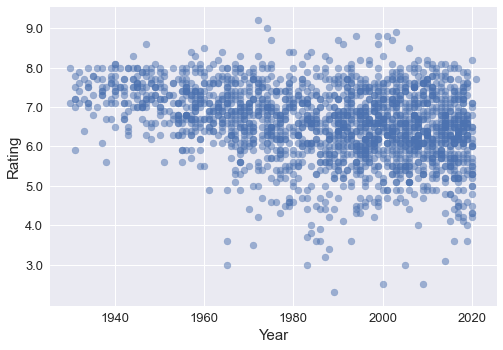

In [80]:
x = movie_df['release_date'].dt.year
y = movie_df['rating']
fig, ax = plt.subplots(1,1)
plt.scatter(x,y,alpha=0.5)
ax.set_title('',fontsize=15)
ax.set_xlabel('Year',fontsize=15)
ax.set_ylabel('Rating',fontsize=15)
ax.set_yticks([3,4,5,6,7,8,9])
ax.set_yticklabels(['3.0','4.0','5.0','6.0','7.0','8.0','9.0'])
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)

(array([3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 3, '3.0'),
  Text(0, 4, '4.0'),
  Text(0, 5, '5.0'),
  Text(0, 6, '6.0'),
  Text(0, 7, '7.0'),
  Text(0, 8, '8.0'),
  Text(0, 9, '9.0')])

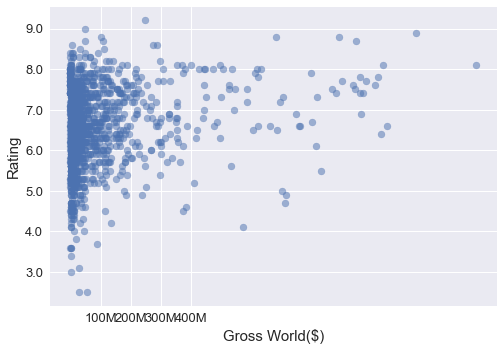

In [81]:
movie_df.dropna(subset=['gross_world'])
x = movie_df['gross_world']
y = movie_df['rating']
fig, ax = plt.subplots(1,1)
plt.scatter(x,y,alpha=0.5)
ax.set_title('',fontsize=15)
ax.set_xlabel('Gross World($)',fontsize=15)
ax.set_ylabel('Rating',fontsize=15)
ax.set_xticks([100e6,200e6,300e6,400e6])
ax.set_xticklabels(['100M','200M','300M','400M'])
ax.set_yticks([3,4,5,6,7,8,9])
ax.set_yticklabels(['3.0','4.0','5.0','6.0','7.0','8.0','9.0'])
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)

(array([3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 3, '3.0'),
  Text(0, 4, '4.0'),
  Text(0, 5, '5.0'),
  Text(0, 6, '6.0'),
  Text(0, 7, '7.0'),
  Text(0, 8, '8.0'),
  Text(0, 9, '9.0')])

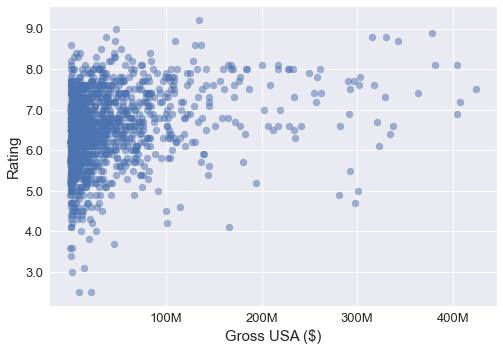

In [82]:
movie_df.dropna(subset=['gross_usa'])
x = movie_df['gross_usa']
y = movie_df['rating']
fig, ax = plt.subplots(1,1)
plt.scatter(x,y,alpha=0.5)
ax.set_title('',fontsize=15)
ax.set_xlabel('Gross USA ($)',fontsize=15)
ax.set_ylabel('Rating',fontsize=15)
ax.set_xticks([100e6,200e6,300e6,400e6])
ax.set_xticklabels(['100M','200M','300M','400M'])
ax.set_yticks([3,4,5,6,7,8,9])
ax.set_yticklabels(['3.0','4.0','5.0','6.0','7.0','8.0','9.0'])
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)

(array([3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 3, '3.0'),
  Text(0, 4, '4.0'),
  Text(0, 5, '5.0'),
  Text(0, 6, '6.0'),
  Text(0, 7, '7.0'),
  Text(0, 8, '8.0'),
  Text(0, 9, '9.0')])

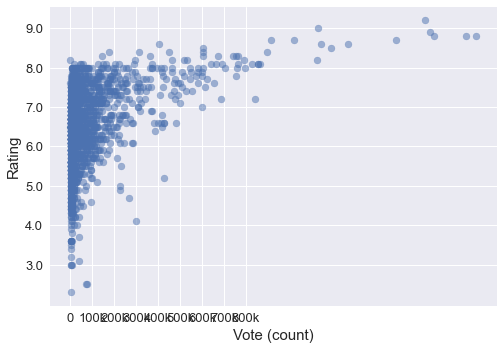

In [83]:
movie_df.dropna(subset=['vote'])
x = movie_df['vote']
y = movie_df['rating']

fig, ax = plt.subplots(1,1)
plt.scatter(x,y,alpha=0.5)
ax.set_title('',fontsize=15)
ax.set_xlabel('Vote (count)',fontsize=15)
ax.set_ylabel('Rating',fontsize=15)
ax.set_xticks([0,100e3,200e3,300e3,400e3,500e3,600e3,700e3,800e3])
ax.set_xticklabels(['0','100k','200k','300k','400k','500k','600k','700k','800k',])
ax.set_yticks([3,4,5,6,7,8,9])
ax.set_yticklabels(['3.0','4.0','5.0','6.0','7.0','8.0','9.0'])
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)

(array([3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 3, '3.0'),
  Text(0, 4, '4.0'),
  Text(0, 5, '5.0'),
  Text(0, 6, '6.0'),
  Text(0, 7, '7.0'),
  Text(0, 8, '8.0'),
  Text(0, 9, '9.0')])

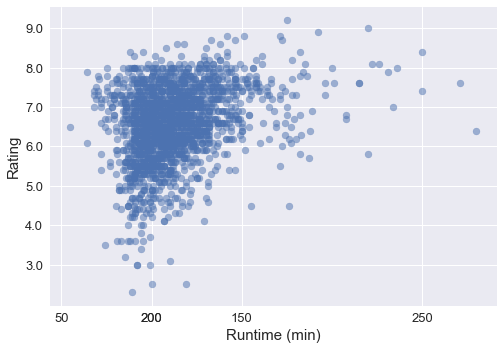

In [84]:
movie_df.dropna(subset=['runtime'])
movie_df = movie_df[movie_df.runtime <300]
x = movie_df['runtime']
y = movie_df['rating']

fig, ax = plt.subplots(1,1)
plt.scatter(x,y,alpha=0.5)
ax.set_title('',fontsize=15)
ax.set_xlabel('Runtime (min)',fontsize=15)
ax.set_ylabel('Rating',fontsize=15)

ax.set_xticks([50,100,150,100,250])
ax.set_xticklabels(['50','100','150','200','250'])
ax.set_yticks([3,4,5,6,7,8,9])
ax.set_yticklabels(['3.0','4.0','5.0','6.0','7.0','8.0','9.0'])
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)

### Construct director DataFrame

In [95]:
# Create list of directors from the 2000 movies
movie_temp = movie_df.drop_duplicates(subset=['director'])
director_list = movie_df.director.unique()

In [90]:
len(director_list)

1095

In [137]:
import numpy as np
import pandas as pd
def get_movie_brief(soup):
    """
    Getting brief data from individual movie webpage (for director dictionary)
    """
    
    headers=['director','title','year','rating','vote','genre_list','budget','opening','gross_usa',\
             'gross_cw','runtime','writer','star','distributor']
    
    # find movie title
    title = " ".join(soup.find('h1').text.split()[:-1])
    
    # find rating
    rating = np.nan
    try:
        rating = float(soup.find('span',attrs={'itemprop':'ratingValue'}).text)
    except:
        pass
    
    # find vote (rating count)
    vote = np.nan
    try:
        vote = int(soup.find('span',attrs={'itemprop':'ratingCount'}).text.replace(',',''))
    except:
        pass
    
    
    # find list of genre
    genre_list=[]
    try:
        for genres in soup.find('div', class_="subtext").find_all('a')[:-1]:
            genre_list.append(genres.text)
    except:
        pass
    
        
    # find release date
    date = np.nan
    try:
        date_pre = soup.find('div', class_="subtext").find_all('a')[-1].text.split('(')[0]
        date = pd.to_datetime(date_pre) ## why is it Timestamp? format ='%d-%B-%Y'
    except:
        pass

    
#     # find metascorre
#     if soup.find('div',class_="metacriticScore score_favorable titleReviewBarSubItem") is not None:
#         meta = int(soup.find('div',class_="metacriticScore score_favorable titleReviewBarSubItem").text.strip('\n'))
#     else:
#         meta = np.nan
        
        
#     # find plot keywords
#     keyword_list=[]
#     for keywords in soup.find('div', class_="article", id="titleStoryLine").\
#     find('div', class_="see-more inline canwrap").find_all('a')[:-1]:
#         keyword_list.append(keywords.text.strip(' '))
        
    
    
    # find budget, opening weekend USA, gross USA, cumulative worldwide gross
    # assign default value:
    budget, opening, gross_usa, gross_cw, distributor = np.nan, np.nan, np.nan, np.nan, np.nan
    try:
        for line in soup.find('div', class_="article", id="titleDetails").find_all('h4'):        
            if "Budget:" in line:
                budget = int(''.join(s for s in line.next_sibling if s.isdigit()))
            if "Opening Weekend USA:" in line:
                opening = int(''.join(s for s in line.next_sibling if s.isdigit()))
            if "Gross USA:" in line:
                gross_usa = int(''.join(s for s in line.next_sibling if s.isdigit()))
            if "Cumulative Worldwide Gross:" in line:
                gross_cw = int(''.join(s for s in line.next_sibling if s.isdigit()))
            if "Production Co:" in line:
                distributor = line.findNext().text.replace(' ','')
    except:
        pass

        
    # find runtime
    runtime = np.nan
    try:
        runtime = int(soup.find_all('time')[-1].text.strip(' min'))
    except:
        pass
        
        
        
        
    # find director
    director= np.nan
    try:
        director = soup.find('div',class_="credit_summary_item").find('a').text
        link_d = soup.find('div',class_="credit_summary_item").find('a').get('href')
    except:
        pass
    
    # find writer
    writer = np.nan
    try:
        writer_line = soup.find_all('div',class_="credit_summary_item")[1].find_all('a')
        link_w = [w.get('href') for w in writer_line]
        writer = [w.text for w in writer_line]
        if '1 more credit' in writer:
            writer.remove('1 more credit')
            link_w.pop()
    except:
        pass
    
        
    # find star
    star = np.nan
    try:
        star_line = soup.find_all('div',class_="credit_summary_item")[2].find_all('a')
        link_s = [s.get('href') for s in star_line]
        star = [s.text for s in star_line]
        if 'See full cast & crew' in star:
            star.remove('See full cast & crew')
            link_s.pop()
    except:
        pass
    
    
    
#     # find language
#     language= np.nan
#     t= []
#     matching = []
#     for div in soup.find('div', class_="article", id="titleDetails").find_all('div'):
#         t.append(div.text.replace('\n','').replace(' ',''))
    
#     matching = [s for s in t if 'Language:' in s]
#     language = matching[0].replace(':',' ').replace('|',' ').split(' ')[1:]
    
    
#     # find country
#     country= np.nan
#     t= []
#     matching = []
#     for div in soup.find('div', class_="article", id="titleDetails").find_all('div'):
#         t.append(div.text.replace('\n','').replace(' ',''))
    
#     matching = [s for s in t if 'Country:' in s]
#     country = matching[0].replace(':',' ').replace('|',' ').split(' ')[1:]
    
        
    movie_dict = dict(zip(headers, [director,
                                    title,
                                    date,
                                    rating,
                                    vote,
                                   genre_list,
                                   budget,
                                   opening,
                                   gross_usa,
                                   gross_cw,
                                   runtime,
                                    writer,
                                    star,
                                   distributor]))
    
    return movie_dict

In [113]:
# Create a dictionary of director: link
director_link_dict = movie_temp[['director','link_d']].set_index('director').T.to_dict('list')

In [115]:
base_url = "https://www.imdb.com"
director = "Francis Ford Coppola"
director_link = "/name/nm0000338/"
director_url = base_url + director_link
director_soup = get_soup(director_url)
films = director_soup.find('div', id="filmo-head-director").findNext('div')
director_dict = {}
headers = ['director',]

for film in films:
    movie = film.find('a')
    if type(movie) != int:
        movie_title = movie.text
        movie_link = movie.get('href')
        
        movie_soup = get_soup(base_url + movie_link)
        movie_brief = get_movie_brief(movie_soup)
        
director_dict = dict(zip(headers, movie_brief))

In [114]:
director_film_list=[]
for film in films:
    movie_title = film.find('a').text
    movie_link = film.find('a').get('href')
    movie_soup = get_soup(base_url + movie_link)
    
    detail = get_movie_brief(movie_soup)
    director_film_list.append(detail)
director_film_list

NameError: name 'films' is not defined

In [133]:
# Create list of films from these 1095 directors

director_film_list=[]
base_url = "https://www.imdb.com"
for director in director_link_dict:
    director_url = base_url + director_link_dict[director][0]
    director_soup = get_soup(director_url)
    films = director_soup.find('div', id="filmo-head-director").findNext('div')
    
    for film in films:
        movie = film.find('a')
        if type(movie) != int:
            movie_title = movie.text
            movie_link = movie.get('href')
            movie_soup = get_soup(base_url + movie_link)
    
            detail = get_movie_brief(movie_soup)
            director_film_list.append(detail)

AttributeError: 'NoneType' object has no attribute 'find_all'

In [134]:
len(director_film_list)

1670

In [173]:
director_link = (movie_temp[['director','link_d']]).reset_index().drop(columns=['index'])

In [174]:
director_link[director_link.director=="Peter Berg"]

,director,link_d
66,Peter Berg,/name/nm0000916/


In [175]:
director_link.iloc[66:]

,director,link_d
66,Peter Berg,/name/nm0000916/
67,Wolfgang Petersen,/name/nm0000583/
68,Tom Hooper,/name/nm0393799/
69,Thea Sharrock,/name/nm4824763/
70,Marc Forster,/name/nm0286975/
...,...,...
1090,Noel Black,/name/nm0085457/
1091,Victor Vicas,/name/nm0895857/
1092,Jeff Kanew,/name/nm0437596/
1093,George Nichols Jr.,/name/nm0629519/


In [177]:
director_link_dict = director_link.iloc[66:].set_index('director').T.to_dict('list')
director_link_dict

{'Peter Berg': ['/name/nm0000916/'],
 'Wolfgang Petersen': ['/name/nm0000583/'],
 'Tom Hooper': ['/name/nm0393799/'],
 'Thea Sharrock': ['/name/nm4824763/'],
 'Marc Forster': ['/name/nm0286975/'],
 'Alfred Hitchcock': ['/name/nm0000033/'],
 'Andrea Di Stefano': ['/name/nm0224331/'],
 'Brian De Palma': ['/name/nm0000361/'],
 'Bill Condon': ['/name/nm0174374/'],
 'Nick Cassavetes': ['/name/nm0001024/'],
 'P.J. Hogan': ['/name/nm0389591/'],
 'Amy Heckerling': ['/name/nm0002132/'],
 'Tim Burton': ['/name/nm0000318/'],
 'Andrew Adamson': ['/name/nm0011470/'],
 'Michael Mann': ['/name/nm0000520/'],
 'Sharon Maguire': ['/name/nm0536632/'],
 'Kelly Reichardt': ['/name/nm0716980/'],
 'Nicolas Winding Refn': ['/name/nm0716347/'],
 'Taylor Hackford': ['/name/nm0000431/'],
 'Susanne Bier': ['/name/nm0081540/'],
 'Adrian Lyne': ['/name/nm0001490/'],
 'Chris Weitz': ['/name/nm0919363/'],
 'Danny DeVito': ['/name/nm0000362/'],
 'Steve McQueen': ['/name/nm2588606/'],
 'Oliver Stone': ['/name/nm0000231

In [181]:
base_url = "https://www.imdb.com"
c = 0
for director in director_link_dict:
    c += 1
    print(c, director)
    director_url = base_url + director_link_dict[director][0]
    director_soup = get_soup(director_url)
    films = director_soup.find('div', id="filmo-head-director").findNext('div')
    
    for film in films:
        movie = film.find('a')
        if type(movie) != int:
            movie_title = movie.text
            movie_link = movie.get('href')
            movie_soup = get_soup(base_url + movie_link)
    
            detail = get_movie_brief(movie_soup)
            director_film_list.append(detail)

1 Peter Berg
2 Wolfgang Petersen
3 Tom Hooper
4 Thea Sharrock
5 Marc Forster
6 Alfred Hitchcock
7 Andrea Di Stefano
8 Brian De Palma
9 Bill Condon
10 Nick Cassavetes
11 P.J. Hogan
12 Amy Heckerling
13 Tim Burton
14 Andrew Adamson
15 Michael Mann
16 Sharon Maguire
17 Kelly Reichardt
18 Nicolas Winding Refn
19 Taylor Hackford
20 Susanne Bier
21 Adrian Lyne
22 Chris Weitz
23 Danny DeVito
24 Steve McQueen
25 Oliver Stone
26 Clint Eastwood
27 Angelina Jolie
28 Fede Alvarez
29 Doug Liman
30 Wes Ball
31 David Frankel
32 Ron Howard
33 Edward Norton
34 David Lean
35 Curtis Hanson
36 Robert Stevenson
37 Richard Attenborough
38 Björn Runge
39 Lasse Hallström
40 Neil Burger
41 Ben Affleck
42 Michael Noer
43 Nancy Meyers
44 Mike Figgis
45 Renny Harlin
46 Victor Fleming
47 Martin Brest
48 Randal Kleiser
49 Ashley Avis
50 Sydney Pollack
51 Mel Stuart
52 Bernardo Bertolucci
53 Rob Marshall
54 James Foley
55 Stuart Rosenberg
56 Tom Tykwer
57 Kevin Costner
58 Ted Kotcheff
59 James Ponsoldt
60 Duncan Jon

460 Mark Mylod
461 Sara Sugarman
462 Jeannot Szwarc
463 Luis Llosa
464 Thomas Bezucha
465 Daniel Petrie Jr.
466 William A. Wellman
467 Barry Alexander Brown
468 James Algar
469 Sylvio Tabet
470 Nora Twomey
471 Don Bluth
472 Geoffrey Sax
473 Ami Canaan Mann
474 Clark Johnson
475 Ted Post
476 Richard Benjamin
477 James Wan
478 Lucky McKee
479 Joseph Kane
480 Mira Nair
481 Carl Reiner
482 Henry Levin
483 Andrzej Bartkowiak
484 Arthur Penn
485 Gil Kenan
486 Hossein Amini
487 Ubaldo Ragona
488 Pella Kagerman
489 Mark Pellington
490 Tod Browning
491 Ewan McGregor
492 Stacie Passon
493 Bille August
494 George Seaton
495 William Peter Blatty
496 Ulu Grosbard
497 Oliver Hirschbiegel
498 Ray Enright
499 Joe Dante
500 Oren Moverman
501 John Schultz
502 Ralph Nelson
503 Boris Sagal
504 Tom Vaughan
505 Stephen Hopkins
506 Johnny Martin
507 Jules Bass
508 Michael Sarne
509 Elliot Silverstein
510 Stacy Title
511 Kevin Lima
512 Dan Wolman
513 Sanaa Hamri
514 Michael Carreras
515 John Hough
516 Walter 

911 Michelle Manning
912 Michael Buster
913 Russell Mulcahy
914 Pen Densham
915 Luis Buñuel
916 James B. Harris
917 Walerian Borowczyk
918 Robert M. Young
919 Michael Almereyda
920 Jim O'Connolly
921 Chuck Jones
922 Max Ophüls
923 Compton Bennett
924 Tia Brelis
925 Jonathan Kahn
926 Frank Borzage
927 Paul Morrissey
928 Hubert Cornfield
929 Walter Grauman
930 Cornel Wilde
931 Yann Samuell
932 Delbert Mann
933 James Bolton
934 John Flynn
935 Allan Dwan
936 Rowland V. Lee
937 Griff Furst
938 Jonas Åkerlund
939 Chris Fisher
940 Adam Simon
941 John Malkovich
942 Sidney Franklin
943 Anatole Litvak
944 Allen Reisner
945 William F. Claxton
946 Justin Lee
947 Jan Egleson
948 Kevin Billington
949 Karl Freund
950 Steve Carver
951 David Greene
952 Fred F. Sears
953 Stephen Gyllenhaal
954 Leif Tilden
955 Edwin Sherin
956 Ed Bianchi
957 Philip Dunne
958 Michael Bortman
959 Alan Rudolph
960 Mitchell Lichtenstein
961 Trygve Allister Diesen
962 David Price
963 John Farrow
964 Pinchas Perry
965 Bernhard

In [182]:
director_df = pd.DataFrame(director_film_list)

In [184]:
director_df

,director,title,year,rating,vote,genre_list,budget,opening,gross_usa,gross_cw,runtime,writer,star,distributor
0,Roger Kumble,After We Collided,2020-10-23,5.0,16469.0,"[Drama, Romance]",NaN,422899.0,2386483.0,47990414.0,105.0,"[Anna Todd, Mario Celaya]","[Josephine Langford, Hero Fiennes Tiffin, Dyla...",CalMaple
1,Roger Kumble,Falling Inn Love,2019-08-29,5.6,15662.0,"[Comedy, Romance]",NaN,NaN,NaN,NaN,98.0,"[Elizabeth Hackett, Hilary Galanoy]","[Christina Milian, Adam Demos, Jeffrey Bowyer-...",NaN
2,I. Marlene King,Pretty Little Liars: The,NaT,7.1,3862.0,"[Crime, Drama, Mystery]",NaN,NaN,NaN,NaN,45.0,"[Sasha Pieterse, Janel Parrish, Sofia Carson, ...",NaN,WarnerHorizonTelevision
3,Aaron Korsh,,NaT,8.5,361371.0,"[Comedy, Drama]",NaN,NaN,NaN,NaN,44.0,"[Gabriel Macht, Patrick J. Adams, Meghan Markl...",NaN,Hypnotic
4,I. Marlene King,Famous in,NaT,6.9,5726.0,"[Drama, Romance]",NaN,NaN,NaN,NaN,42.0,"[Bella Thorne, Charlie DePew, Carter Jenkins, ...",NaN,FarahFilms
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32077,Guy Green,The Snorkel,1958-07-07,6.8,1191.0,"[Crime, Horror, Mystery]",100000.0,NaN,NaN,NaN,90.0,"[Peter Myers, Jimmy Sangster]","[Peter van Eyck, Betta St. John, Mandy Miller]",ColumbiaPicturesCorporation
32078,Guy Green,Triple Deception,1956-11-19,6.0,160.0,"[Crime, Drama, Thriller]",NaN,NaN,NaN,NaN,97.0,"[Sterling Noel, Robert Buckner]","[Michael Craig, Julia Arnall, Brenda de Banzie]",TheRankOrganisation
32079,Guy Green,Tears for Simon,1957-01-04,6.4,296.0,"[Crime, Mystery, Thriller]",NaN,NaN,NaN,NaN,89.0,[Janet Green],"[David Farrar, David Knight, Julia Arnall]",SydneyBoxProductions
32080,Guy Green,Postmark for Danger,1956-01-18,6.4,455.0,"[Crime, Drama, Mystery]",NaN,NaN,NaN,NaN,78.0,"[Ken Hughes, Guy Green]","[Robert Beatty, Terry Moore, William Sylvester]",InsigniaFilms


In [183]:
# Save the data to pickle file
director_df.to_pickle('../dump/director_data')

In [124]:
director = 'Roger Kumble'
director_url = base_url + director_link_dict[director][0]
director_soup = get_soup(director_url)
films = director_soup.find('div', id="filmo-head-director").findNext('div')

for film in films:
    movie = film.find('a')
    if type(movie) != int:
        movie_title = movie.text
        movie_link = movie.get('href')
        movie_soup = get_soup(base_url + movie_link)

        detail = get_movie_brief(movie_soup)
        director_film_list.append(detail)

,director,link_d
66,Peter Berg,/name/nm0000916/


director          Peter Berg
link_d      /name/nm0000916/
Name: 66, dtype: object

In [162]:
director_link.iloc[66:]

,director,link_d
66,Peter Berg,/name/nm0000916/
67,Wolfgang Petersen,/name/nm0000583/
68,Tom Hooper,/name/nm0393799/
69,Thea Sharrock,/name/nm4824763/
70,Marc Forster,/name/nm0286975/
...,...,...
1090,Noel Black,/name/nm0085457/
1091,Victor Vicas,/name/nm0895857/
1092,Jeff Kanew,/name/nm0437596/
1093,George Nichols Jr.,/name/nm0629519/


In [170]:
director_link

{'Peter Berg': ['/name/nm0000916/'],
 'Wolfgang Petersen': ['/name/nm0000583/'],
 'Tom Hooper': ['/name/nm0393799/'],
 'Thea Sharrock': ['/name/nm4824763/'],
 'Marc Forster': ['/name/nm0286975/'],
 'Alfred Hitchcock': ['/name/nm0000033/'],
 'Andrea Di Stefano': ['/name/nm0224331/'],
 'Brian De Palma': ['/name/nm0000361/'],
 'Bill Condon': ['/name/nm0174374/'],
 'Nick Cassavetes': ['/name/nm0001024/'],
 'P.J. Hogan': ['/name/nm0389591/'],
 'Amy Heckerling': ['/name/nm0002132/'],
 'Tim Burton': ['/name/nm0000318/'],
 'Andrew Adamson': ['/name/nm0011470/'],
 'Michael Mann': ['/name/nm0000520/'],
 'Sharon Maguire': ['/name/nm0536632/'],
 'Kelly Reichardt': ['/name/nm0716980/'],
 'Nicolas Winding Refn': ['/name/nm0716347/'],
 'Taylor Hackford': ['/name/nm0000431/'],
 'Susanne Bier': ['/name/nm0081540/'],
 'Adrian Lyne': ['/name/nm0001490/'],
 'Chris Weitz': ['/name/nm0919363/'],
 'Danny DeVito': ['/name/nm0000362/'],
 'Steve McQueen': ['/name/nm2588606/'],
 'Oliver Stone': ['/name/nm0000231

In [106]:
director_link = movie_temp[['director','link_d']].set_index('director').T.to_dict('list')

In [109]:
director_link['Christopher Nolan'][0]

'/name/nm0634240/'